In [1]:
# =============================================================================
# HUMAN ACTIVITY RECOGNITION - COMPLETE PROJECT CODE
# =============================================================================

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold
import os
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")


/data/mptc20/mptc20/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


✅ Libraries imported successfully!


In [2]:
# =============================================================================
# 1. DATA LOADING - CORRECTED FOR NESTED STRUCTURE
# =============================================================================

class HARDataLoader:
    def __init__(self, allow_fallback=False):
        self.allow_fallback = allow_fallback
        self.activity_labels = {
            1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS',
            4: 'SITTING', 5: 'STANDING', 6: 'LAYING'
        }
    
    def _build_paths(self, base_path):
        """Centralise all dataset file paths in one place."""
        train_dir = os.path.join(base_path, 'train')
        test_dir = os.path.join(base_path, 'test')

        paths = {
            'X_train': os.path.join(train_dir, 'X_train.txt'),
            'y_train': os.path.join(train_dir, 'y_train.txt'),
            'subject_train': os.path.join(train_dir, 'subject_train.txt'),
            'X_test': os.path.join(test_dir, 'X_test.txt'),
            'y_test': os.path.join(test_dir, 'y_test.txt'),
            'subject_test': os.path.join(test_dir, 'subject_test.txt'),
            'features': os.path.join(base_path, 'features.txt'),
        }
        return paths


    def load_data(self):
        """Load data from the nested folder structure"""
        print("📁 Loading dataset from nested structure...")
        
        base_path = os.path.join('UCI HAR Dataset')
        print(f"Using path: {base_path}")
        
        if self._check_data_exists(base_path):
            print("✅ All files found! Loading REAL data...")
            return self._load_from_path(base_path)

        msg = (
            "UCI HAR Dataset files not found at the expected path. "
            f"Checked base path: {base_path}. "
            "Please verify the folder location and structure."
        )
        print(f"❌ {msg}")

        if self.allow_fallback:
            print("⚠️ Fallback enabled: creating sample data for development only.")
            return self._create_sample_data()

        raise FileNotFoundError(msg)

    
    def _check_data_exists(self, base_path):
        """Check if data exists at the nested path"""
        if not os.path.exists(base_path):
            print(f"❌ Base path doesn't exist: {base_path}")
            return False
        
        paths = self._build_paths(base_path)
        
        required_files = [
            paths['X_train'],
            paths['y_train'],
            paths['subject_train'],
            paths['X_test'],
            paths['y_test'],
            paths['subject_test'],
            paths['features']
        ]

        
        print("🔍 Checking files in nested folder...")
        all_exist = True
        for file_path in required_files:
            if os.path.exists(file_path):
                print(f"   ✅ {os.path.basename(file_path)}")
            else:
                print(f"   ❌ {os.path.basename(file_path)}")
                all_exist = False
        
        return all_exist
    
    def _load_from_path(self, base_path):
        """Load data from the nested path"""
        try:
            paths = self._build_paths(base_path)

            print("\n📥 Loading training data...")
            X_train = pd.read_csv(paths['X_train'], sep=r'\s+', header=None)
            y_train = pd.read_csv(paths['y_train'], sep=r'\s+', header=None, names=['activity'])
            subject_train = pd.read_csv(paths['subject_train'], sep=r'\s+', header=None, names=['subject'])

            print("📥 Loading test data...")
            X_test = pd.read_csv(paths['X_test'], sep=r'\s+', header=None)
            y_test = pd.read_csv(paths['y_test'], sep=r'\s+', header=None, names=['activity'])
            subject_test = pd.read_csv(paths['subject_test'], sep=r'\s+', header=None, names=['subject'])

            print("📥 Loading feature names...")
            with open(paths['features'], 'r') as f:
                feature_names = [line.strip().split()[1] for line in f]

            
            # Set column names
            X_train.columns = feature_names
            X_test.columns = feature_names
            
            # Map activity numbers to names
            y_train['activity_name'] = y_train['activity'].map(self.activity_labels)
            y_test['activity_name'] = y_test['activity'].map(self.activity_labels)
            
            print(f"\n🎉 REAL DATA LOADED SUCCESSFULLY FROM NESTED FOLDER!")
            print(f"   Training set: {X_train.shape}")
            print(f"   Test set: {X_test.shape}")
            print(f"   Features: {len(feature_names)}")
            print(f"   Subjects: {pd.concat([subject_train, subject_test])['subject'].nunique()}")
            
            # Show activity distribution
            print(f"\n📊 Activity Distribution:")
            activity_counts = y_train['activity_name'].value_counts().sort_index()
            for activity, count in activity_counts.items():
                percentage = (count / len(y_train)) * 100
                print(f"   {activity:<20}: {count:>4} samples ({percentage:5.1f}%)")
            
            return X_train, X_test, y_train, y_test, subject_train, subject_test, feature_names
            
        except Exception as e:
            print(f"❌ Error loading data: {e}")
            import traceback
            traceback.print_exc()
            return None
    
    def _create_sample_data(self):
        """Create sample data as fallback"""
        print("🔄 Creating sample data for development...")
        n_train, n_test = 7352, 2947
        n_features = 561
        
        np.random.seed(42)
        X_train = pd.DataFrame(np.random.randn(n_train, n_features))
        X_test = pd.DataFrame(np.random.randn(n_test, n_features))
        
        feature_names = [f'feature_{i:03d}' for i in range(n_features)]
        X_train.columns = feature_names
        X_test.columns = feature_names
        
        activities = list(self.activity_labels.values())
        y_train = pd.DataFrame({
            'activity': np.random.choice([1,2,3,4,5,6], n_train),
            'activity_name': np.random.choice(activities, n_train)
        })
        y_test = pd.DataFrame({
            'activity': np.random.choice([1,2,3,4,5,6], n_test), 
            'activity_name': np.random.choice(activities, n_test)
        })
        
        subject_train = pd.DataFrame({'subject': np.random.randint(1, 31, n_train)})
        subject_test = pd.DataFrame({'subject': np.random.randint(1, 31, n_test)})
        
        print("✅ Sample data created")
        return X_train, X_test, y_train, y_test, subject_train, subject_test, feature_names

# Load data
print("\n" + "="*60)
print("STEP 1: DATA LOADING - NESTED STRUCTURE")
print("="*60)
data_loader = HARDataLoader(allow_fallback=False)
X_train, X_test, y_train, y_test, subject_train, subject_test, feature_names = data_loader.load_data()

groups_train = subject_train['subject'].values


STEP 1: DATA LOADING - NESTED STRUCTURE
📁 Loading dataset from nested structure...
Using path: UCI HAR Dataset
🔍 Checking files in nested folder...
   ✅ X_train.txt
   ✅ y_train.txt
   ✅ subject_train.txt
   ✅ X_test.txt
   ✅ y_test.txt
   ✅ subject_test.txt
   ✅ features.txt
✅ All files found! Loading REAL data...

📥 Loading training data...
📥 Loading test data...
📥 Loading feature names...

🎉 REAL DATA LOADED SUCCESSFULLY FROM NESTED FOLDER!
   Training set: (7352, 561)
   Test set: (2947, 561)
   Features: 561
   Subjects: 30

📊 Activity Distribution:
   LAYING              : 1407 samples ( 19.1%)
   SITTING             : 1286 samples ( 17.5%)
   STANDING            : 1374 samples ( 18.7%)
   WALKING             : 1226 samples ( 16.7%)
   WALKING_DOWNSTAIRS  :  986 samples ( 13.4%)
   WALKING_UPSTAIRS    : 1073 samples ( 14.6%)


In [3]:
# =============================================================================
# 2. DATA PREPROCESSING
# =============================================================================

print("\n" + "="*60)
print("STEP 2: DATA PREPROCESSING")
print("="*60)

# Feature scaling is handled inside each model's Pipeline
# to prevent leakage during cross-validation.

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train['activity_name'])
y_test_encoded = label_encoder.transform(y_test['activity_name'])

print("✅ Data preprocessing completed!")
print(f"   Classes: {label_encoder.classes_}")



STEP 2: DATA PREPROCESSING
✅ Data preprocessing completed!
   Classes: ['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']



STEP 3: EXPLORATORY DATA ANALYSIS


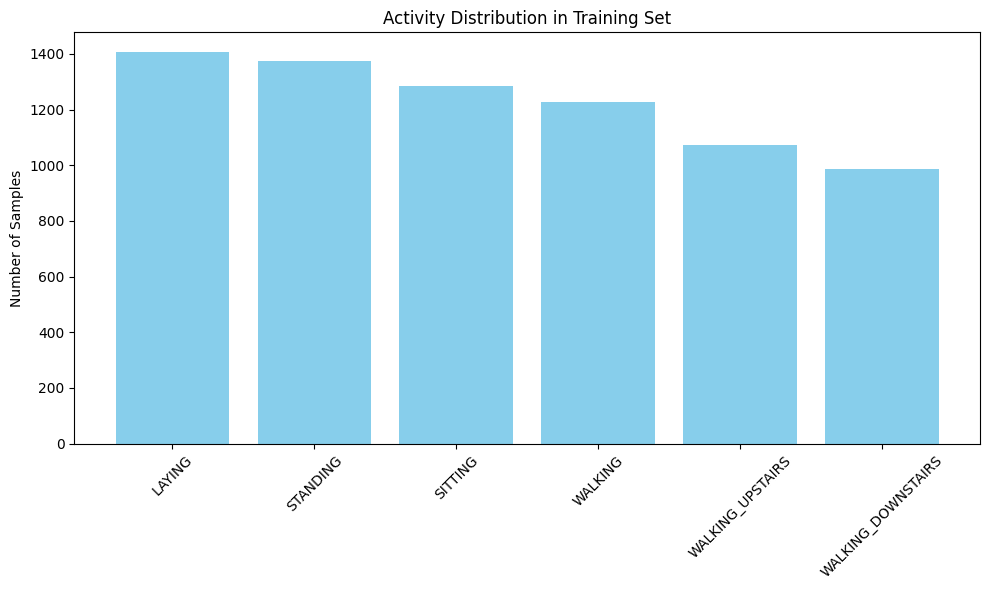

📊 Activity Distribution:
   LAYING              : 1407 samples
   STANDING            : 1374 samples
   SITTING             : 1286 samples
   WALKING             : 1226 samples
   WALKING_UPSTAIRS    : 1073 samples
   WALKING_DOWNSTAIRS  : 986 samples


In [4]:

# =============================================================================
# 3. EXPLORATORY DATA ANALYSIS
# =============================================================================

print("\n" + "="*60)
print("STEP 3: EXPLORATORY DATA ANALYSIS")
print("="*60)

# Activity distribution
plt.figure(figsize=(10, 6))
activity_counts = y_train['activity_name'].value_counts()
plt.bar(activity_counts.index, activity_counts.values, color='skyblue')
plt.title('Activity Distribution in Training Set')
plt.xticks(rotation=45)
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()

print("📊 Activity Distribution:")
for activity, count in activity_counts.items():
    print(f"   {activity:<20}: {count} samples")


In [5]:

# =============================================================================
# 4. MODEL TRAINING (3 MODELS)
# =============================================================================

print("\n" + "="*60)
print("STEP 4: TRAINING THREE MODELS")
print("="*60)

class ModelTrainer:
    def __init__(self):
        self.models = {}
        self.results = {}
    
    def train_models(self, X_train, y_train, groups_train):
        """Train three models using pipelines"""

        configs = {
            'Random Forest': {
                'model': Pipeline([
                    ('scaler', 'passthrough'),
                    ('clf', RandomForestClassifier(random_state=42))
                ]),
                'params': {
                    'clf__n_estimators': [150, 175, 200],
                    'clf__max_depth': [8, 9, 10]
                }
            },
            'SVM': {
                'model': Pipeline([
                    ('scaler', StandardScaler()),
                    ('clf', SVC(random_state=42, probability=True))
                ]),
                'params': {
                    'clf__C': [1, 10, 100],
                    'clf__gamma': ['scale']
                }
            },
            'Neural Network': {
                'model': Pipeline([
                    ('scaler', StandardScaler()),
                    ('clf', MLPClassifier(random_state=42, max_iter=1000))
                ]),
                'params': {
                    'clf__hidden_layer_sizes': [(75,), (50,), (25,)],
                    'clf__alpha': [0.001]
                }
            }
        }
        
        for name, config in configs.items():
            print(f"🔧 Training {name}...")
            gkf = GroupKFold(n_splits=5)

            grid_search = GridSearchCV(
                config['model'],
                config['params'],
                cv=gkf,
                scoring='accuracy',
                return_train_score=True
            )

            grid_search.fit(X_train, y_train, groups=groups_train)


            best_model = grid_search.best_estimator_
            train_predictions = best_model.predict(X_train)
            train_accuracy = accuracy_score(y_train, train_predictions)
            print(f"   🔍 Training Accuracy: {train_accuracy:.4f}")

            self.results[name] = {
                'cv_score': grid_search.best_score_,
                'best_params': grid_search.best_params_,
                'cv_results': grid_search.cv_results_
            }

            self.models[name] = best_model
            print(f"   ✅ CV Accuracy: {grid_search.best_score_:.4f}")
    
    def evaluate_models(self, X_test, y_test):
        """Evaluate all models"""
        print("\n📊 MODEL EVALUATION:")
        evaluation = {}
        
        for name, model in self.models.items():
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            evaluation[name] = {
                'accuracy': accuracy,
                'predictions': y_pred,
                'model': model
            }
            print(f"   {name:<20}: Test Accuracy = {accuracy:.4f}")
        
        best_model = max(evaluation.keys(), key=lambda x: evaluation[x]['accuracy'])
        print(f"\n🏆 BEST MODEL: {best_model} (Accuracy: {evaluation[best_model]['accuracy']:.4f})")
        
        return evaluation


# Train models
trainer = ModelTrainer()
trainer.train_models(X_train, y_train_encoded, groups_train)
results = trainer.evaluate_models(X_test, y_test_encoded)

def time_inference(model, X, repeats=10):
    
    _ = model.predict(X[:10])

    times = []
    for _ in range(repeats):
        start = time.perf_counter()
        _ = model.predict(X)
        end = time.perf_counter()
        times.append(end - start)

    return float(np.mean(times)), float(np.std(times))

rows = []
n_test = X_test.shape[0]

for name, model in trainer.models.items():
    mean_s, std_s = time_inference(model, X_test, repeats=10)    
    per_sample_ms = (mean_s / n_test) * 1000.0

    rows.append({
        "Model": name,
        "Batch inference time (s) mean": mean_s,
        "Batch inference time (s) std": std_s,
        "Approx per-sample latency (ms)": per_sample_ms
    })

inference_df = (
    pd.DataFrame(rows)
      .sort_values("Batch inference time (s) mean")
      .reset_index(drop=True)
)

print("\n" + "="*60)
print("INFERENCE TIME SUMMARY")
print("="*60)
print(inference_df.to_string(index=False))

# Hyperparameter performance summary (from stored GridSearchCV results)

print("\n" + "="*60)
print("HYPERPARAMETER PERFORMANCE SUMMARY")
print("="*60)

for model_name, info in trainer.results.items():
    print(f"\n--- {model_name} ---")
    print("Best Parameters:", info['best_params'])
    print(f"Best CV Accuracy: {info['cv_score']:.4f}")

    # Convert CV results to DataFrame for summarising
    cv_df = pd.DataFrame(info['cv_results'])
    key_params = [c for c in cv_df.columns if 'param_' in c]
    summary_cols = key_params + ['mean_train_score', 'mean_test_score', 'std_test_score']

    print("\nGrid Search Results:")
    print(cv_df[summary_cols].sort_values('mean_test_score', ascending=False).to_string(index=False))




STEP 4: TRAINING THREE MODELS
🔧 Training Random Forest...
   🔍 Training Accuracy: 0.9927
   ✅ CV Accuracy: 0.9231
🔧 Training SVM...
   🔍 Training Accuracy: 0.9981
   ✅ CV Accuracy: 0.9243
🔧 Training Neural Network...
   🔍 Training Accuracy: 1.0000
   ✅ CV Accuracy: 0.9341

📊 MODEL EVALUATION:
   Random Forest       : Test Accuracy = 0.9172
   SVM                 : Test Accuracy = 0.9542
   Neural Network      : Test Accuracy = 0.9437

🏆 BEST MODEL: SVM (Accuracy: 0.9542)

INFERENCE TIME SUMMARY
         Model  Batch inference time (s) mean  Batch inference time (s) std  Approx per-sample latency (ms)
Neural Network                       0.009875                      0.000580                        0.003351
 Random Forest                       0.030384                      0.004885                        0.010310
           SVM                       1.168484                      0.019631                        0.396500

HYPERPARAMETER PERFORMANCE SUMMARY

--- Random Forest ---
Best Par


STEP 5: RESULTS VISUALIZATION


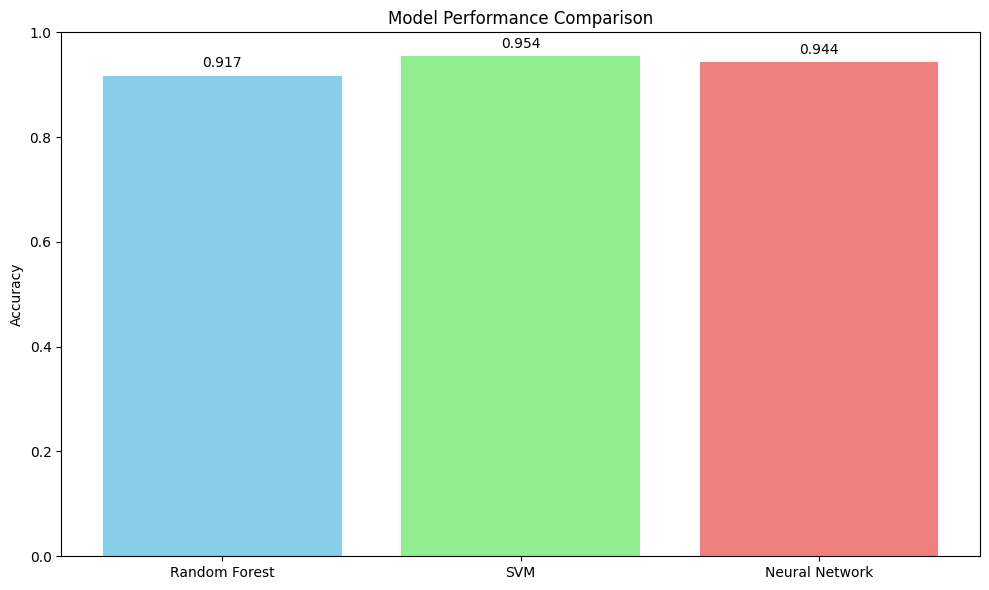


CLASSIFICATION REPORTS

--- Random Forest Classification Report ---
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.91      0.87      0.89       491
          STANDING       0.89      0.92      0.90       532
           WALKING       0.86      0.97      0.91       496
WALKING_DOWNSTAIRS       0.96      0.83      0.89       420
  WALKING_UPSTAIRS       0.90      0.88      0.89       471

          accuracy                           0.92      2947
         macro avg       0.92      0.91      0.91      2947
      weighted avg       0.92      0.92      0.92      2947


--- SVM Classification Report ---
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.96      0.89      0.93       491
          STANDING       0.91      0.97      0.94       532
           WALKING       0.95      0.97      0.96   

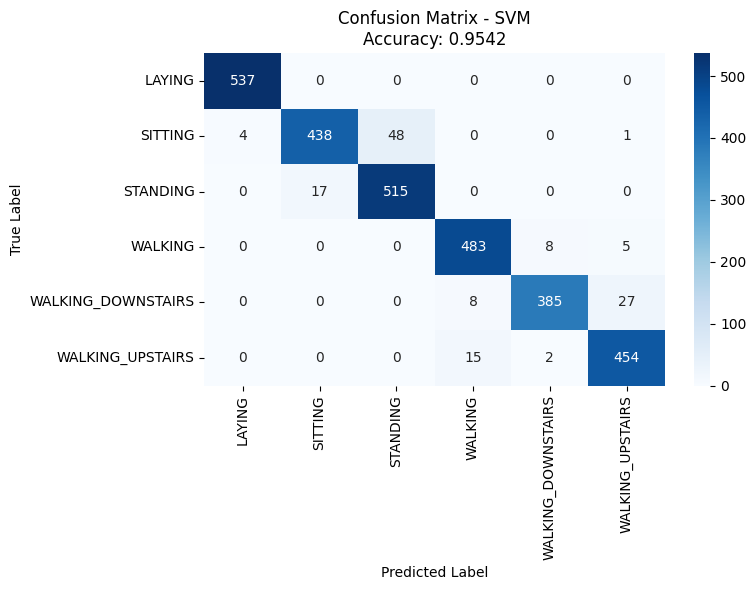

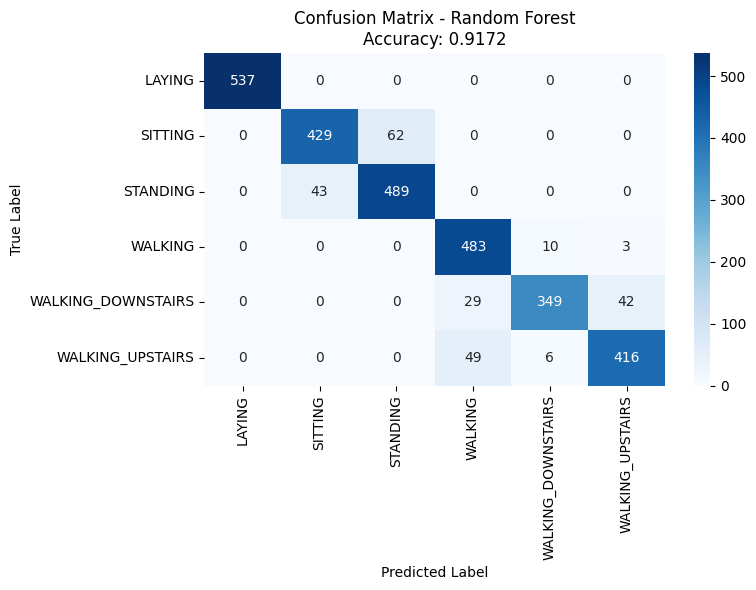

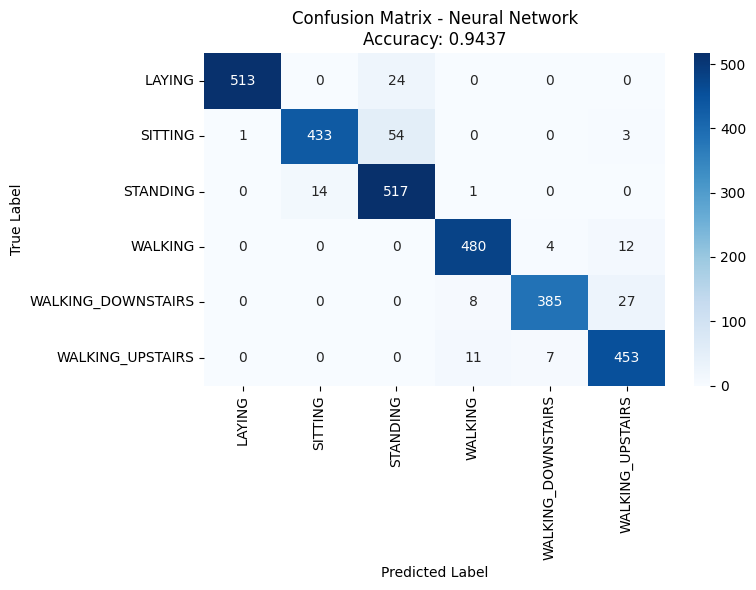


PCA VISUALIZATION - 2D SCATTER PLOT


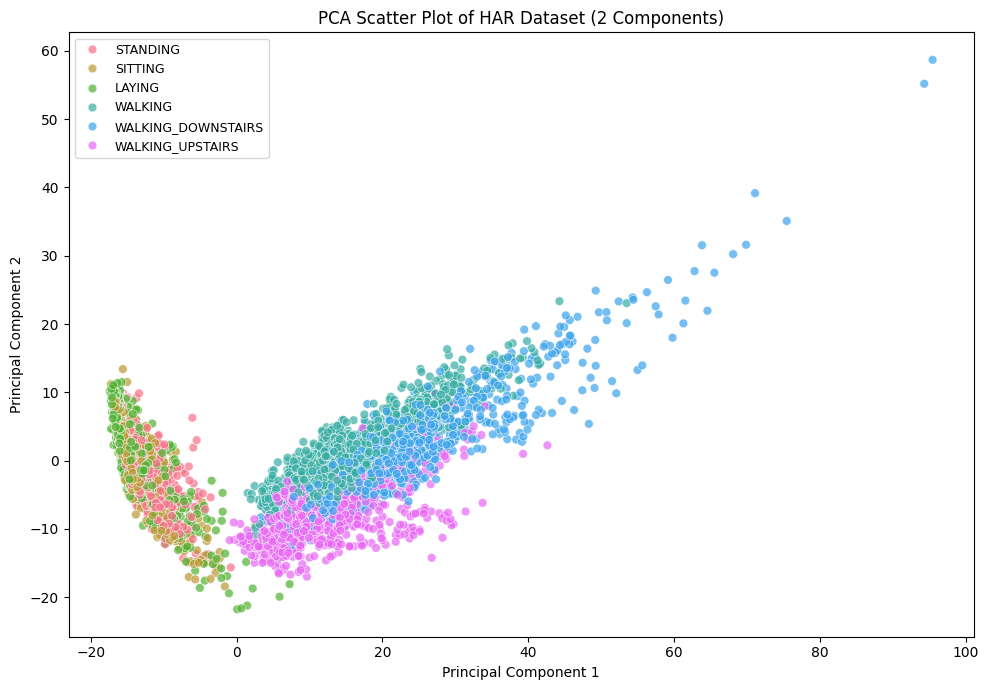

Explained variance by PC1 and PC2: 57.36%

LEARNING CURVES


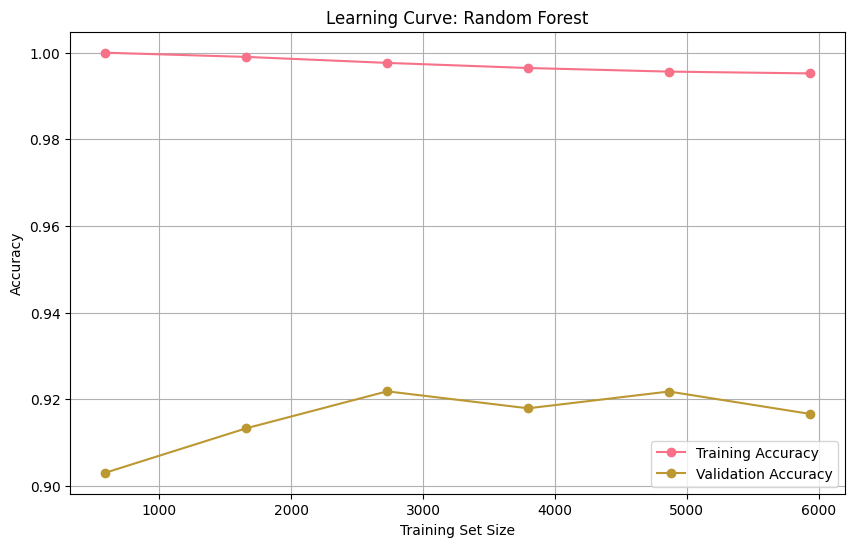

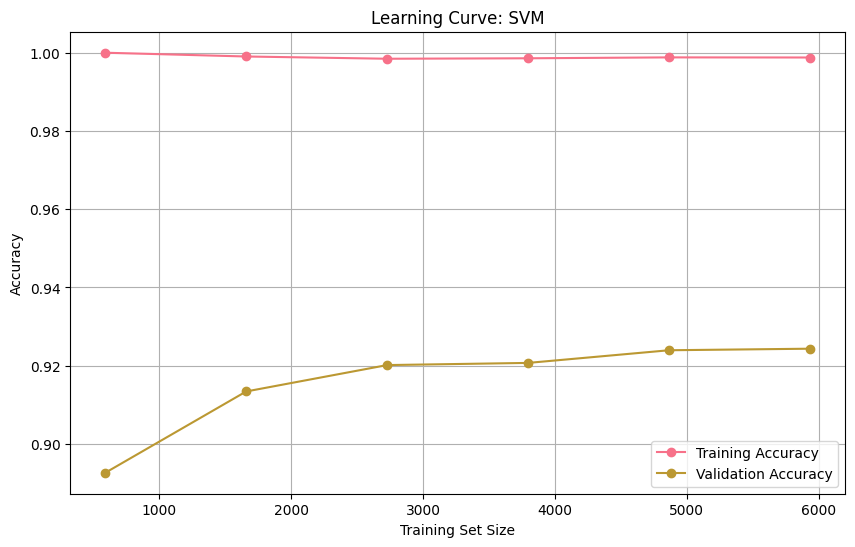

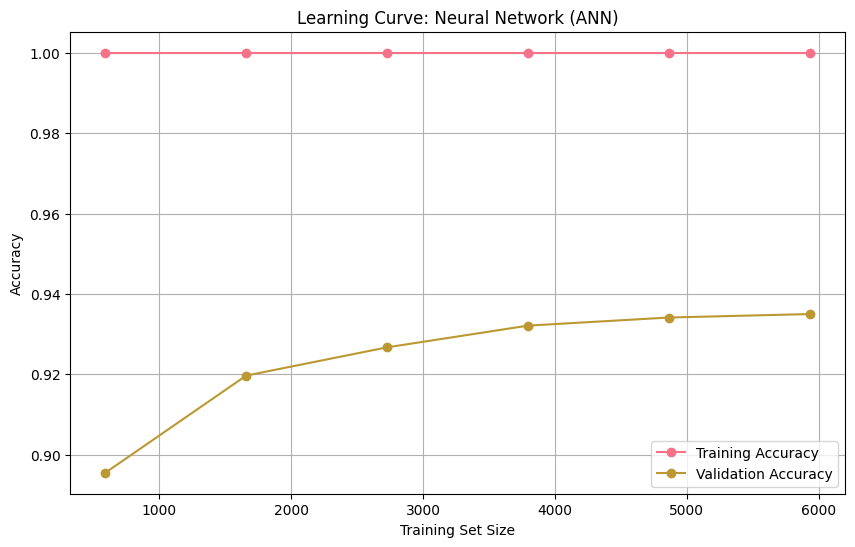


Plotting ANN Loss Curve...


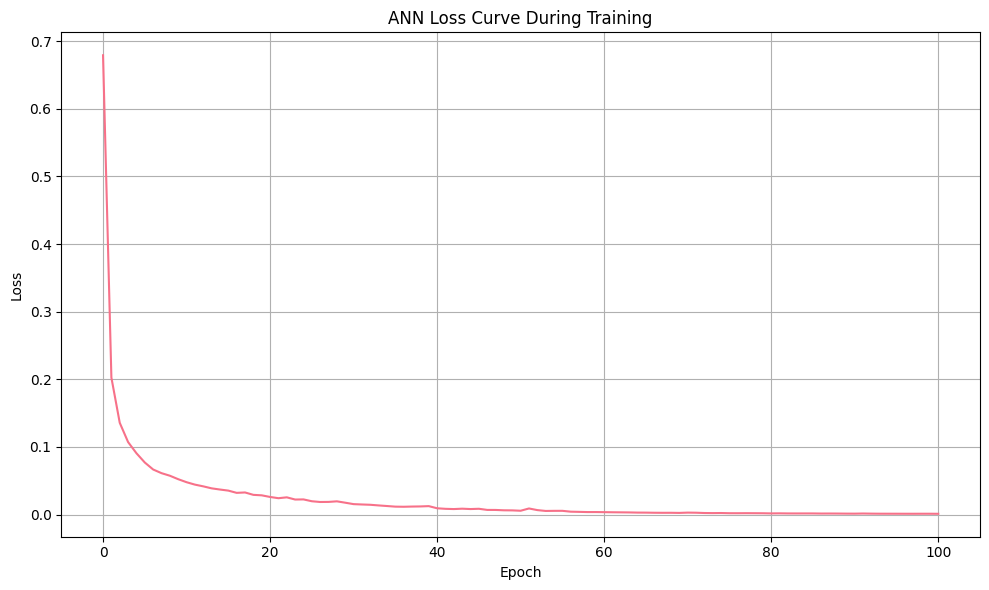


RANDOM FOREST - TOP FEATURE IMPORTANCES

Top 20 most important features:

 1. tGravityAcc-mean()-X                     Importance: 0.038304
 2. tGravityAcc-mean()-Y                     Importance: 0.031197
 3. angle(X,gravityMean)                     Importance: 0.029689
 4. tGravityAcc-energy()-X                   Importance: 0.029590
 5. tGravityAcc-min()-X                      Importance: 0.029314
 6. tGravityAcc-min()-Y                      Importance: 0.026651
 7. tGravityAcc-max()-X                      Importance: 0.022425
 8. angle(Y,gravityMean)                     Importance: 0.020562
 9. tGravityAcc-max()-Y                      Importance: 0.020320
10. tGravityAcc-energy()-Y                   Importance: 0.018601
11. fBodyAcc-mad()-X                         Importance: 0.012532
12. tBodyAcc-max()-X                         Importance: 0.011377
13. tGravityAcc-arCoeff()-Z,1                Importance: 0.011286
14. fBodyAccMag-energy()                     Importance: 0.010683
1

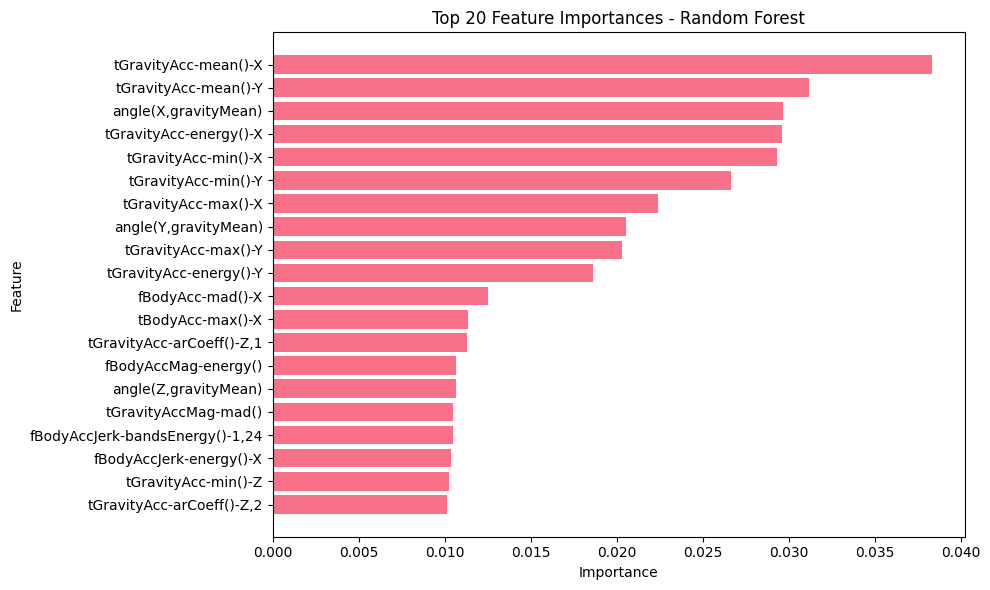

In [6]:

# =============================================================================
# 5. RESULTS VISUALIZATION
# =============================================================================

print("\n" + "="*60)
print("STEP 5: RESULTS VISUALIZATION")
print("="*60)

# Model comparison
models = list(results.keys())
accuracies = [results[model]['accuracy'] for model in models]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Print classification reports for all models
print("\n" + "="*60)
print("CLASSIFICATION REPORTS")
print("="*60)

for model_name in results.keys():
    print(f"\n--- {model_name} Classification Report ---")
    y_pred = results[model_name]['predictions']
    print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))


# Confusion matrix for best model
best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
best_predictions = results[best_model_name]['predictions']

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_encoded, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}\nAccuracy: {results[best_model_name]["accuracy"]:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Confusion matrices for Random Forest and Neural Network (ANN)
for model_name in ['Random Forest', 'Neural Network']:
    if model_name in results:
        model_predictions = results[model_name]['predictions']
        
        plt.figure(figsize=(8, 6))
        cm_model = confusion_matrix(y_test_encoded, model_predictions)
        sns.heatmap(
            cm_model,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_
        )
        plt.title(f'Confusion Matrix - {model_name}\nAccuracy: {results[model_name]["accuracy"]:.4f}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

# Scatter Plot (PCA)

print("\n" + "="*60)
print("PCA VISUALIZATION - 2D SCATTER PLOT")
print("="*60)

# PCA to reduce to 2 components
pca_scaler = StandardScaler()
X_train_for_pca = pca_scaler.fit_transform(X_train)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_for_pca)

# DataFrame for easy plotting
pca_df = pd.DataFrame({
    'PC1': X_train_pca[:, 0],
    'PC2': X_train_pca[:, 1],
    'Activity': y_train['activity_name']
})

# Plot PCA scatter
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Activity',
    palette='husl',
    s=40,
    alpha=0.7
)

plt.title("PCA Scatter Plot of HAR Dataset (2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc='best', fontsize=9)
plt.tight_layout()
plt.show()

# Print explained variance
print(f"Explained variance by PC1 and PC2: {pca.explained_variance_ratio_.sum():.2%}")

# Learning Curves

def plot_learning_curve(model, X, y, title, groups):
    gkf = GroupKFold(n_splits=5)

    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        cv=gkf,
        groups=groups,
        scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 6),
        shuffle=True,
        random_state=42
    )
    
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n" + "="*60)
print("LEARNING CURVES")
print("="*60)

# Random Forest
plot_learning_curve(
    trainer.models['Random Forest'],
    X_train,
    y_train_encoded,
    "Learning Curve: Random Forest",
    groups_train
)

# SVM
plot_learning_curve(
    trainer.models['SVM'],
    X_train,
    y_train_encoded,
    "Learning Curve: SVM",
    groups_train
)

# Neural Network (MLP)
plot_learning_curve(
    trainer.models['Neural Network'],
    X_train,
    y_train_encoded,
    "Learning Curve: Neural Network (ANN)",
    groups_train
)

# ANN loss curve

print("\nPlotting ANN Loss Curve...")

ann_pipe = trainer.models['Neural Network']  # Pipeline
ann = ann_pipe.named_steps['clf']            # MLPClassifier

plt.figure(figsize=(10, 6))
plt.plot(ann.loss_curve_)
plt.title("ANN Loss Curve During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importance (RF)

print("\n" + "="*60)
print("RANDOM FOREST - TOP FEATURE IMPORTANCES")
print("="*60)

# Get the trained RF model
rf_pipe = trainer.models['Random Forest']
rf_model = rf_pipe.named_steps['clf']  # RandomForestClassifier

# Feature importances
rf_importances = rf_model.feature_importances_

# Sort features by importance (descending)
indices = np.argsort(rf_importances)[::-1]
top_n = 20

print(f"\nTop {top_n} most important features:\n")
for i in range(top_n):
    feature_idx = indices[i]
    print(f"{i+1:2d}. {feature_names[feature_idx]:<40} Importance: {rf_importances[feature_idx]:.6f}")

# Plot the top N features
plt.figure(figsize=(10, 6))
top_indices = indices[:top_n]
plt.barh(
    [feature_names[i] for i in top_indices][::-1],
    rf_importances[top_indices][::-1]
)
plt.title(f"Top {top_n} Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [7]:

# =============================================================================
# 6. FINAL SUMMARY
# =============================================================================

print("\n" + "="*60)
print("PROJECT COMPLETED SUCCESSFULLY! 🎉")
print("="*60)
print("\n📋 SUMMARY:")
print(f"   • Dataset: Human Activity Recognition Using Smartphones")
print(f"   • Samples: {X_train.shape[0]} training, {X_test.shape[0]} test")
print(f"   • Features: {X_train.shape[1]} time/frequency domain features")
print(f"   • Activities: {len(label_encoder.classes_)} daily activities")
print(f"   • Models: 3 different ML models implemented and compared")
print(f"   • Best Model: {best_model_name}")

print("   The models are trained and evaluated successfully.")


PROJECT COMPLETED SUCCESSFULLY! 🎉

📋 SUMMARY:
   • Dataset: Human Activity Recognition Using Smartphones
   • Samples: 7352 training, 2947 test
   • Features: 561 time/frequency domain features
   • Activities: 6 daily activities
   • Models: 3 different ML models implemented and compared
   • Best Model: SVM
   The models are trained and evaluated successfully.
